# Training data for mitosis detection using deep learning
Notebook to create template list and make mitosis detection data usable by deep learning. 

## Data
A image series consisting of 399 phase contrast images with 552 labeled mitotic events is used. The training data is available as template images where each mitotic cell is stored in an image with size 41x41. Each filename is "frame_x-coord_y-coord.png". 

##  Training data for keras-rcnn 
To make the data **keras-rcnn ready** we create a list containg the bounding box for each mitosis. See
 https://github.com/broadinstitute/keras-rcnn

## The mitosis data was published in 2013, see link below. 

```
@inproceedings{becker2013combining,
  title={Combining phase contrast and immunofluorescence images using geometric hashing},
  author={Becker, Tim and Schultz, Sandra and Rapoport, Daniel H and Mamlouk, Amir Madany},
  booktitle={Biomedical Imaging (ISBI), 2013 IEEE 10th International Symposium on},
  pages={906--909},
  year={2013},
  organization={IEEE}
}
```

6.2017 TB

In [1]:
%matplotlib notebook 

import json
import numpy 
import os
import sys
import time

import skimage.io
import skimage.transform
import skimage.color

import matplotlib.pyplot
import matplotlib.patches

In [2]:
# directory storing 399 phase contrast image data belonging to cetres data
imageDir = '../../../../refdata_mitosis/cetres.b/image-contrast_2/'

# load image given the image number
def getImage(frameNr, imageDir):
    imageName = 'refdataB_C2_' + "%03i.png" % (frameNr,)
    image =  skimage.io.imread(imageDir + imageName)
    return skimage.color.rgb2gray(image)

# 
def getImageName(frameNr, imageDir):
    return('refdataB_C2_' + "%03i.png" % (frameNr,))

# json file used for export 
fileOut = 'cetres-mitoses.json'

refdataB_C2_101.png


<IPython.core.display.Javascript object>


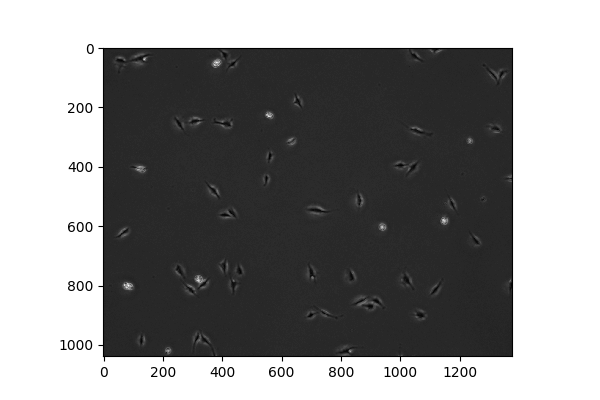

In [3]:
# show sample image
frame = 101
print(getImageName(frame,imageDir))
cellImage = getImage(frame, imageDir)
fig, ax = matplotlib.pyplot.subplots(figsize=(6, 4))
ax.imshow(cellImage, cmap = "gray")

We use .split() to extract the frame, x and y coordinate from each filename.  

In [4]:
# directory containing mitosis templates 
templateDir = '../../../../refdata_mitosis/cetres.b-mi/mitotic_cells/'
templateFileList = os.listdir(templateDir)

templatesPerFrame = {}
for fileName in templateFileList:
    frame, x, y = fileName.replace(".png","").split("_")
    frame = int(frame) 
    x = int(x) 
    y = int(y)
    try: templatesPerFrame[frame].append( (x,y) )
    except: templatesPerFrame[frame] = [ (x,y) ]

## Plot bounding boxes in a time series 
In the following code two ways are shown to plot bounding boxes. 
The first uses matplotlib.patches; this is the most convenient one. The second version plots the bounding boxes using the x y coordinates and a imple plot() command. The second version is used to test if the bounding boxes stored in the json file are correct. 

<IPython.core.display.Javascript object>


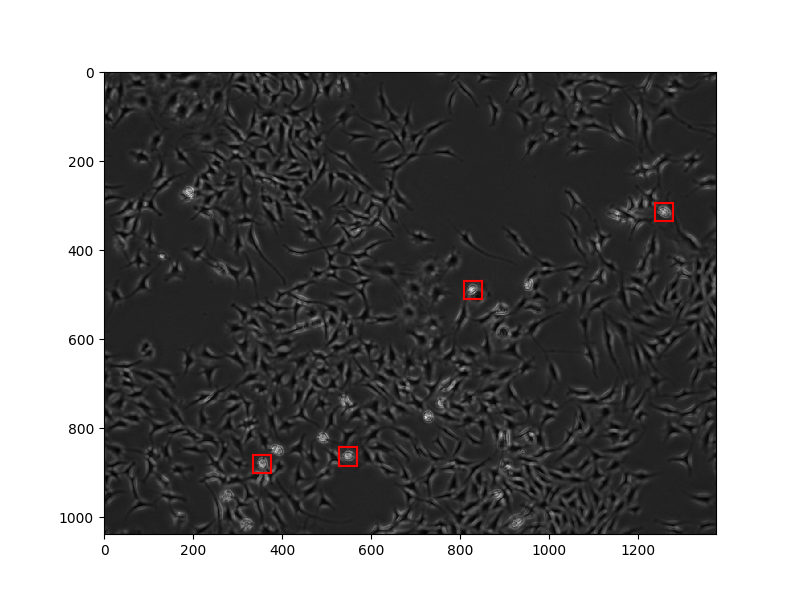

In [5]:
# plot bounding boxes 

fig, ax = matplotlib.pyplot.subplots(figsize=(8, 6))

for frame in range(1,399,10):   
    # clear axis to remove patches (rect objects)
    matplotlib.pyplot.cla()
    cellImage = getImage(frame, imageDir)
    ax.imshow(cellImage,cmap='gray')
    # ignore frames withou any mitotic events
    if frame in templatesPerFrame:
        for corner in templatesPerFrame[frame]:
            #rect = matplotlib.patches.Rectangle(corner, 41, 41, fill=False, edgecolor='red', linewidth=2)
            #ax.add_patch(rect)
            x1 = corner[0]
            x2 = (x1 + 41) 
            y1 = corner[1] 
            y2 = (y1 + 41)
            matplotlib.pyplot.plot([x1, x2], [y1, y1], 'r-')
            matplotlib.pyplot.plot([x1, x2], [y2, y2], 'r-')
            matplotlib.pyplot.plot([x2, x2], [y1, y2], 'r-')
            matplotlib.pyplot.plot([x1, x1], [y1, y2], 'r-')
    # make each frame visible
    fig.canvas.draw()
  

## Export template list as json file

To use the keras-rcnn implementation a training data file is created storing. This data file is a json file storing the filename and the bounding boxes of the training objects in the images. 

We follow the format in the example data from Hung et al. that can be downloaded at http://keras-rcnn.storage.googleapis.com/malaria.tar.gz


In [6]:
# directory containing mitosis templates 
templateDir = '../../../../refdata_mitosis/cetres.b-mi/mitotic_cells/'
templateFileList = os.listdir(templateDir)

templatesPerImage = {}
for templateFileName in templateFileList:
    frame, x, y = templateFileName.replace(".png","").split("_")
    
    imageName = getImageName(int(frame),imageDir)
    x = int(x) 
    y = int(y)
    
    try: templatesPerImage[imageName].append( (x,y) )
    except: templatesPerImage[imageName] = [ (x,y) ]

In [7]:
# loop over all image
templates = []
for key in templatesPerImage:
    t = {}
    boxes = []
    for xy in templatesPerImage[key]:
        x = xy[0]
        y = xy[1]
        bbox = { "class" : "mitosis", "x1" : x, "x2" : (x + 41) , "y1" : y, "y2" : (y + 41)} 
        boxes.append(bbox)
    
    t = {"boxes" : boxes, "filename" : key, "shape" : [1376, 1038, 3] }
    templates.append(t)  
    
with open(fileOut, 'w') as fp:
    json.dump(templates, fp, indent=4)